In [140]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [356]:
Europe = nx.Graph()
countries = pd.read_csv('countries.csv')
Europe.add_nodes_from(countries['country'])

land_borders_countries = pd.read_csv('land_borders_countries.csv')

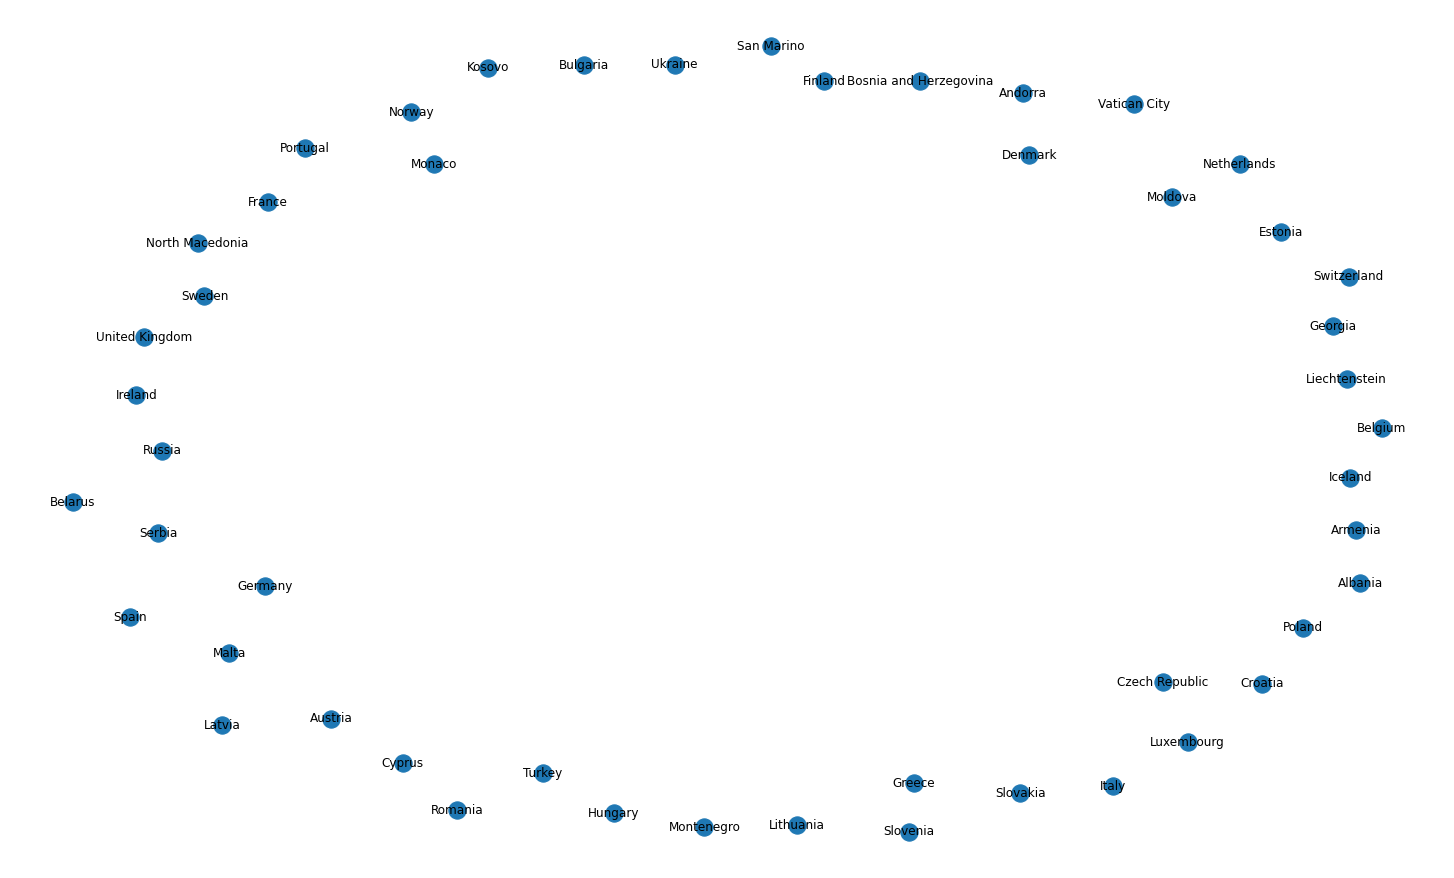

In [357]:
plt.figure(figsize=(20, 12))
nx.draw(Europe, with_labels=True)

In [358]:
sheet_id = '1XqOtPkiE_Q0dfGSoyxrH730RkwrTczcRbDeJJpqRByQ'
sheet_name = 'borders'
url = f'https://docs.google.com/spreadsheets/d/1AYODVslftthH3aI8gS0d4wgyLZwwXMpD4bQOSv5M4GI/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df = pd.read_csv(url)
df

,Country or territory\n*(Territories without full sovereignty in italics)* [2],Total length of land borders km[3],mi,No. of distinct land borders,No. of distinct land neighbours,Land border neighbours\nand border length\n\n*(Territories without full sovereignty in italics) [2](#) = No. of distinct \nland boundaries with that country or territory*
0,* Abkhazia*,382,237,2.0,2.0,Russia: 241 km (150 mi)\n Georgia: 141 km (88 mi)
1,* Afghanistan*,"5,529","3,436",6.0,6.0,People's Republic of China: 76 km (47 mi)\n Ir...
2,* Albania*,720,450,4.0,4.0,Greece: 282 km (175 mi)\n* Kosovo*:[4] 112 km ...
3,* Algeria*,"6,47","4,02",7.0,7.0,"Libya: 982 km (610 mi)\n Mali: 1,376 km (855 m..."
4,* Andorra*,120,75,2.0,2.0,France: 56.6 km (35.2 mi)\n Spain: 63.7 km (39...
...,...,...,...,...,...,...
200,* Vietnam*,"4,639","2,883",3.0,3.0,"Cambodia: 1,228 km (763 mi)\n People's Republi..."
201,* Western Sahara*[5],"2,046","1,271",3.0,3.0,"Algeria: 42 km (26 mi)\n Mauritania: 1,561 km ..."
202,* Yemen*,"1,746","1,085",2.0,2.0,"Oman: 288 km (179 mi)\n Saudi Arabia: 1,458 km..."
203,* Zambia*,"5,667","3,521",8.0,8.0,"Angola: 1,110 km (690 mi)\n Botswana: 0.15 km ..."


In [203]:
df.columns

Index(['Country or territory\n*(Territories without full sovereignty in italics)* [2] ',
       'Total length of land borders km[3]', 'mi',
       'No. of distinct land borders ', 'No. of distinct land neighbours ',
       'Land border neighbours\nand border length\n\n*(Territories without full sovereignty in italics) [2](#) = No. of distinct \nland boundaries with that country or territory* '],
      dtype='object')

In [359]:
borders = df.rename(columns={'Country or territory\n*(Territories'
                   ' without full sovereignty in italics)* [2] ': \
                   'country',
                   'Land border neighbours\nand border'
                   ' length\n\n*(Territories without full sovereignty in italics) '
                   '[2](#) = No. of distinct \nland boundaries with that country or territory* ': \
                   'neighbours'
                  }).drop(columns=['Total length of land borders km[3]', 'mi', 'No. of distinct land borders ', 'No. of distinct land neighbours '], axis=1)
borders

,country,neighbours
0,* Abkhazia*,Russia: 241 km (150 mi)\n Georgia: 141 km (88 mi)
1,* Afghanistan*,People's Republic of China: 76 km (47 mi)\n Ir...
2,* Albania*,Greece: 282 km (175 mi)\n* Kosovo*:[4] 112 km ...
3,* Algeria*,"Libya: 982 km (610 mi)\n Mali: 1,376 km (855 m..."
4,* Andorra*,France: 56.6 km (35.2 mi)\n Spain: 63.7 km (39...
...,...,...
200,* Vietnam*,"Cambodia: 1,228 km (763 mi)\n People's Republi..."
201,* Western Sahara*[5],"Algeria: 42 km (26 mi)\n Mauritania: 1,561 km ..."
202,* Yemen*,"Oman: 288 km (179 mi)\n Saudi Arabia: 1,458 km..."
203,* Zambia*,"Angola: 1,110 km (690 mi)\n Botswana: 0.15 km ..."


In [360]:
borders = df.rename(columns={'Country or territory\n*(Territories'
                   ' without full sovereignty in italics)* [2] ': \
                   'country',
                   'Land border neighbours\nand border'
                   ' length\n\n*(Territories without full sovereignty in italics) '
                   '[2](#) = No. of distinct \nland boundaries with that country or territory* ': \
                   'neighbours'
                  }).drop(columns=['Total length of land borders km[3]', 'mi', 'No. of distinct land borders ', 'No. of distinct land neighbours '], axis=1)
borders['country'] = borders['country'].str.replace('*', '').str.strip()
borders['country'] = borders['country'].str.replace(r'\[([0-9_]+)\]', '', regex=True) \
    .str.replace(r'\(([0-9_])+\)', '', regex=True)
# borders['neighbours'] = borders['neighbours'].str.split('\n')
borders.at[62, 'country'] = 'France'
borders.at[130, 'country'] = 'Netherlands'
# borders.sample(20)

/var/folders/6d/jcsgnwtj1857x2zvzznd28jw0000gn/T/ipykernel_1212/3368958005.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  borders['country'] = borders['country'].str.replace('*', '').str.strip()


In [361]:
edges_df = countries.merge(borders, how='left')
# edges_df['neighbours'] = edges_df['neighbours'].apply(str)
# edges_df['neighbours'] = [x.split(':')[0] for x in edges_df['neighbours']]
edges_df['neighbours'] =  edges_df['neighbours'].str.split('\n')
edges_df.head()

,country,neighbours
0,Armenia,"[Azerbaijan (6): 787 km (489 mi)[8], Georgia:..."
1,Albania,"[Greece: 282 km (175 mi), * Kosovo*:[4] 112 km..."
2,Andorra,"[France: 56.6 km (35.2 mi), Spain: 63.7 km (3..."
3,Austria,"[Czech Republic: 362 km (225 mi), Germany: 78..."
4,Belarus,"[Latvia: 141 km (88 mi), Lithuania: 502 km (3..."


In [365]:
edges_df['neighbours'] = edges_df['neighbours'].fillna("").apply(list)

In [368]:
for index, row in edges_df.iterrows():
    for neighbour in row['neighbours']:
        temp = neighbour.split(':')[0].replace('*', '')
        temp = re.sub("\[([0-9_]+)\]", "", temp)
        temp = re.sub("\(([0-9_])+\)", "", temp)
        temp = temp.strip()
        if temp in list(edges_df['country']):
            # print(row['country'], temp)
            Europe.add_edge(row['country'], temp)


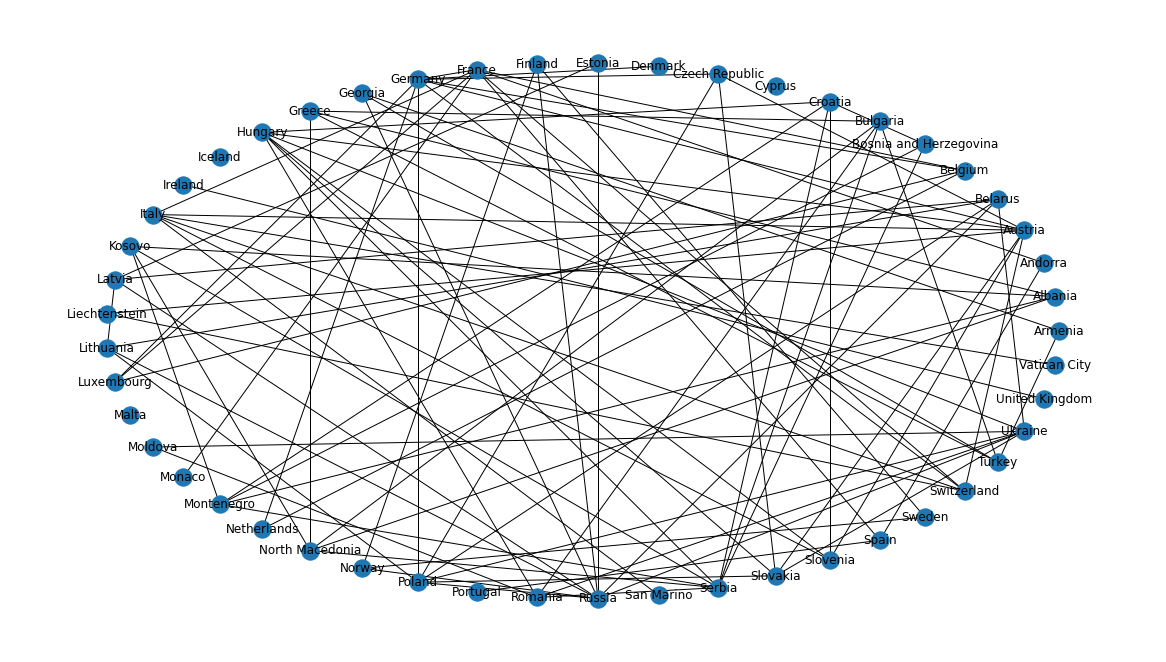

In [371]:
plt.figure(figsize=(16, 9))
nx.draw_circular(Europe, with_labels=True)